<center><img src="https://github.com/DACSS-CSSmeths/guidelines/blob/main/pics/small_logo_ccs_meths.jpg?raw=true" width="700"></center>







-------

# **Homework 1: Spatial AutoCorrelation**

Anjelica Martinez

---



## **I. Preparation**

**I1. Load libraries and data**

In [1]:
!pip -q install geopandas libpysal esda

# Import libraries used for spatial data handling, analysis, and visualization
import geopandas as gpd           # handling geospatial vector data
import numpy as np                # numerical operations
import pandas as pd               # data manipulation
from libpysal.graph import Graph  # spatial weights / neighborhood graphs
import esda                       # exploratory spatial data analysis (LISA)
import matplotlib.pyplot as plt   # plotting

# Set a random seed to ensure reproducible results
from numpy.random import seed
seed(42)


**I2. Read Peru map from GitHub**

In [2]:
# Save peru map file from github url to this variable
LinkPeru="https://raw.githubusercontent.com/DACSS-Anjelica/Homework_1/main/PeruMaps.gpkg"

# read the same layer used in the tutorial
peru = gpd.read_file(LinkPeru, layer='good_geom')

**I3. Review the map data**

According to this output:
* the CRS is 4326
* the map is projected
* the geom shape is multipolygonal
* there are 1,873 rows and 10 columns.

In [3]:
# Check the coordinate reference system (CRS) and confirm it is EPSG:4326
peru.crs.to_epsg(),\

# Check whether the CRS is projected (False indicates a geographic CRS)
peru.crs.is_projected, \

# Identify the geometry type(s) present in the dataset (e.g., MultiPolygon)
set(peru.geom_type),\

# Display the data types of each column in the GeoDataFrame
peru.dtypes, \

# Display the shape of the dataset (number of rows and columns)
peru.shape

(1873, 10)

**I5. Focus on the Lima departamiento**

In [4]:
# Filter the dataset to include only districts belonging to the
# department of Lima for the analysis.
lima = peru.loc[peru["DEPARTAMENTO"] == "Lima"].copy()

## **II. Neighborhood**

In [5]:
# Builds a Queen contiguity spatial neighbor graph where districts are neighbors
# if they share a boundary or a corner.
lima_queen = Graph.build_contiguity(lima, rook=False)

# Normalize the Queen spatial weights using row-standardization.
lima_queen = lima_queen.transform("r")

# Build a K-nearest neighbors spatial graph (k = 8) using representative points
knn8_lima = Graph.build_knn(lima.representative_point(), k=8)

# Normalize the KNN spatial weights using row-standardization so that
# each district’s neighbor weights sum to 1.
knn8_lima = knn8_lima.transform("r")

### **III. LISA**

<Axes: >

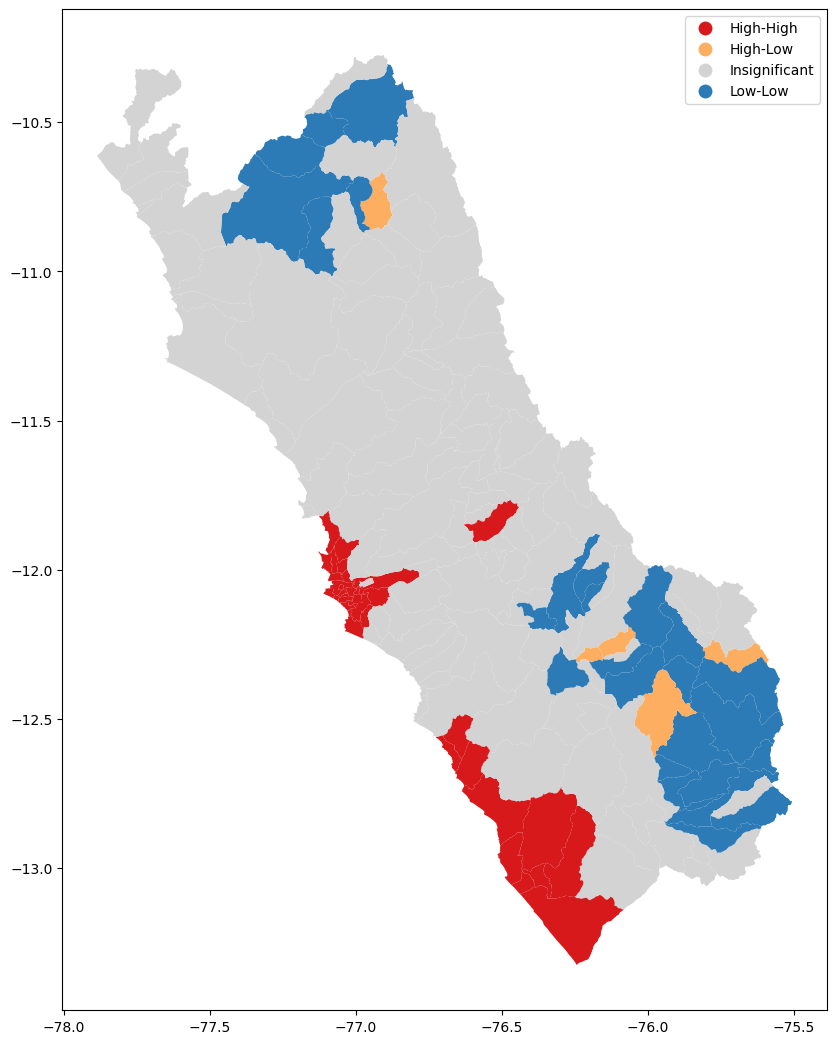

In [6]:
# Run LISA (Local Moran’s I) for the education variable using Queen weights.
lisa = esda.Moran_Local(lima['Educ_sec_comp2019_pct'], lima_queen)

# Plot the LISA cluster map using Queen weights, highlighting statistically
# significant clusters and outliers at the 0.05 significance level.
lisa.plot(lima, crit_value = 0.05, figsize = (10, 13), legend = True)


In [7]:
# Get the LISA cluster (quadrant) labels for each district using Queen weights
# at the 0.05 significance level.
lima.loc[:, "HS_lisa_queen"] = lisa.get_cluster_labels(crit_value=0.05)

In [8]:
# Define the original LISA cluster labels returned by the analysis
oldLabels = ['Insignificant', 'Low-Low', 'High-High', 'High-Low', 'Low-High']

# Define new, custom labels to rename the LISA categories for clarity and ordering
# (with 'no_pattern' placed in the middle).
newLabels = ['3 no_pattern', '4 coldSpot','2 hotSpot','1 hotOutlier' , '5 coldOutlier']

# Create a dictionary that maps the original LISA labels to the new custom labels
labels = dict(zip(oldLabels, newLabels))

# Display the label-mapping dictionary
labels

{'Insignificant': '3 no_pattern',
 'Low-Low': '4 coldSpot',
 'High-High': '2 hotSpot',
 'High-Low': '1 hotOutlier',
 'Low-High': '5 coldOutlier'}

In [9]:
# Replace the original LISA cluster labels with the custom labels
# defined in the label-mapping dictionary.
lima.replace({'HS_lisa_queen':labels},inplace=True)

### **Spatial Autocorrelation**

**Moran's LISA with `knn8_lima`**

<Axes: >

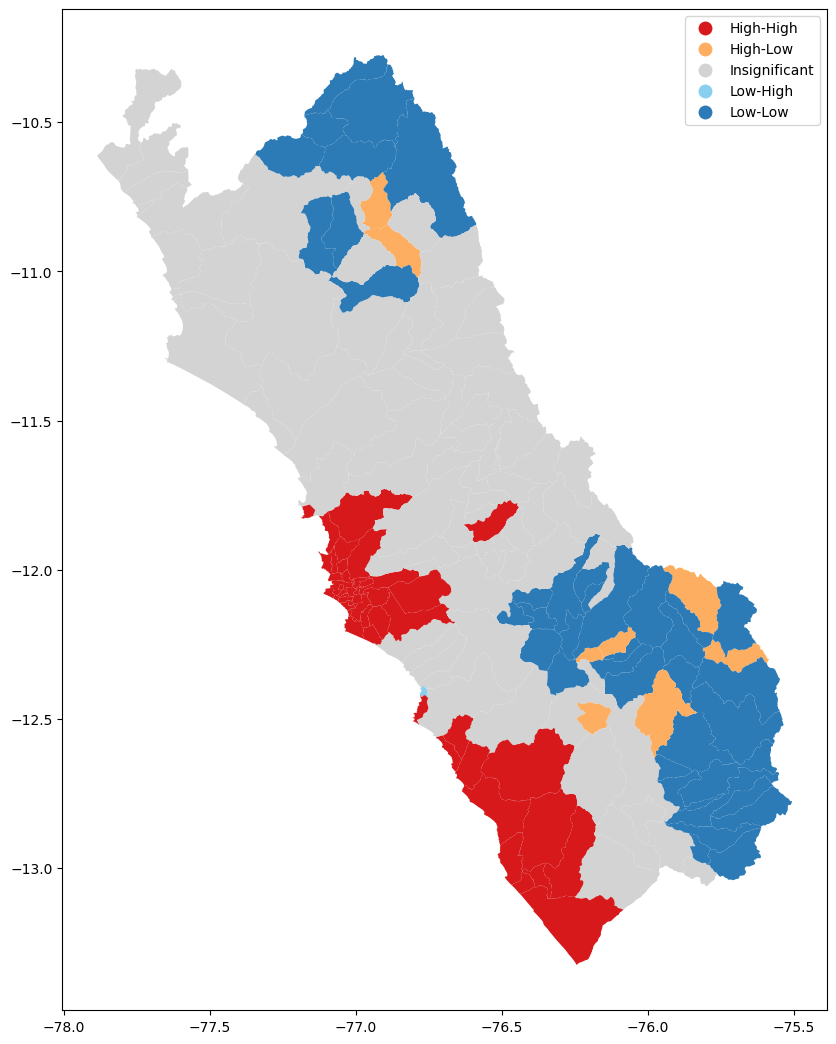

In [10]:
# Compute Local Moran’s I (LISA) for the education variable using
# the K-nearest neighbors (k = 8) spatial weights.
lisa_knn8 = esda.Moran_Local(lima['Educ_sec_comp2019_pct'], knn8_lima)

# Plot the LISA cluster map using K-nearest neighbors (k = 8) weights,
# highlighting statistically significant clusters and outliers at the 0.05 level.
lisa_knn8.plot(lima, crit_value = 0.05, figsize = (10, 13), legend = True)


In [11]:
# Get the LISA cluster (quadrant) labels for each district using
# the K-nearest neighbors (k = 8) weights at the 0.05 significance level.
# Replace the original KNN-based LISA cluster labels with the custom labels
# defined in the label-mapping dictionary.

lima.loc[:, "HS_lisa_knn8"] = lisa_knn8.get_cluster_labels(crit_value=0.05)
lima.loc[:, "HS_lisa_knn8"] = lima["HS_lisa_knn8"].replace(labels)


---
### **Report**:
**Identify districts that change LISA category between Queen and KNN (k=8)**

In [12]:
# Identify districts that change LISA category between Queen and KNN (k=8)
changed_districts = lima.loc[
    lima["HS_lisa_queen"] != lima["HS_lisa_knn8"],
    ["DISTRITO", "HS_lisa_queen", "HS_lisa_knn8"]
]

changed_districts

,DISTRITO,HS_lisa_queen,HS_lisa_knn8
54,AMBAR,4 coldSpot,3 no_pattern
224,CARABAYLLO,3 no_pattern,2 hotSpot
257,CAUJUL,4 coldSpot,3 no_pattern
315,CHECRAS,3 no_pattern,1 hotOutlier
390,CIENEGUILLA,3 no_pattern,2 hotSpot
396,COAYLLO,3 no_pattern,2 hotSpot
450,COPA,3 no_pattern,4 coldSpot
479,CUENCA,3 no_pattern,4 coldSpot
544,GORGOR,3 no_pattern,4 coldSpot
557,HONGOS,3 no_pattern,4 coldSpot


The following districts do not share the same LISA category when comparing Queen vs. KNN (k = 8) neighborhoods:

AMBAR; CARABAYLLO; CAUJUL; CHECRAS; CIENEGUILLA; COAYLLO; COPA; CUENCA; GORGOR; HONGOS; HUANCAYA; HUANEC; HUANGASCAR; LAHUAYTAMBO; LEONCIO PRADO; MADEAN; MARIATANA; NAVAN; OYON; PACHACAMAC; PUCUSANA; SAN JUAN DE LURIGANCHO; SAN LORENZO DE QUINTI; SAN PEDRO DE PILAS; SANGALLAYA; SANTA ANITA; SANTA MARIA DEL MAR; SANTA ROSA; TOMAS; VILLA EL SALVADOR; VILLA MARIA DEL TRIUNFO; VITIS.

*(Their Queen category and KNN category are shown in the table above.)*